In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import gym
from gym import spaces

import gym_minigrid
from gym_minigrid.wrappers import ReseedWrapper, FullyObsWrapper
from gym_minigrid.minigrid import IDX_TO_COLOR, IDX_TO_OBJECT, STATE_TO_IDX, DIR_TO_VEC, OBJECT_TO_IDX

from wombats.systems import LavaComparison

from collections import defaultdict
from bidict import bidict
import itertools

# the main environment we're testing on
ENV_ID = 'MiniGrid-LavaComparison_noDryingOff-v0'
# ENV_ID = 'MiniGrid-LavaGapS5-v0'

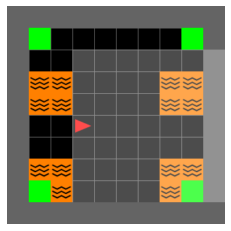

In [2]:
env = FullyObsWrapper(ReseedWrapper(gym.make(ENV_ID), seeds=[0]))

def render(environment):
    plt.imshow(environment.render(mode='rgb_image'), interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
def state_only_obs(obs):
    
    cell_obs = obs['image']
    
    (num_cols, num_rows, num_cell_props) = cell_obs.shape
    
    for i in range(num_rows):
        for j in range(num_cols):
            cell_prop = cell_obs[j, i]
    
    return cell_obs
    
def state_only_obs_reset(environment):
    obs = environment.reset()
    return state_only_obs(obs), environment
    
def state_only_obs_step(environment, action):
    obs, reward, done, _ = environment.step(action)
    return state_only_obs(obs), reward, done, {}, environment

def get_agent_props(environment):
    base_env = environment.unwrapped
    return tuple(base_env.agent_pos), base_env.agent_dir

def set_agent_props(environment, position=None, direction=None):
    base_env = environment.unwrapped
    
    if position is not None:
        base_env.agent_pos = position
    
    if direction is not None:
        base_env.agent_dir = direction

    return environment

def get_env_prop(environment, env_property_name):
    
    base_env = environment.unwrapped
    
    return getattr(base_env, env_property_name)

def set_env_prop(environment, env_property_name, env_property):
    
    base_env = environment.unwrapped
    setattr(base_env, env_property_name, env_property)
    
    return environment

obs, env = state_only_obs_reset(env);
render(env)

In [3]:
IDX_TO_STATE = dict(zip(STATE_TO_IDX.values(), STATE_TO_IDX.keys()))
DIR_TO_STRING = bidict({0: 'right', 1: 'down', 2: 'left', 3: 'up'})

def obs_to_props(environment, obs, row_idx, col_idx):

    obj_type, obj_color, obj_state = obs[col_idx, row_idx]
    agent_pos, _ = get_agent_props(environment)
    is_agent = (col_idx, row_idx) == tuple(agent_pos)
    
    prop_string_base = '_'.join([IDX_TO_OBJECT[obj_type], IDX_TO_COLOR[obj_color]])

    if is_agent:
        return '_'.join([prop_string_base, DIR_TO_STRING[obj_state]])
    else:
        return '_'.join([prop_string_base, IDX_TO_STATE[obj_state]])

In [4]:
def get_action_str(action_enum):
    
    action_str = str(action_enum)
    
    # string version of Action.done is 'Action.done' -> trim 
    substring_to_trim = 'Actions.'
    action_str = action_str[len(substring_to_trim):]
    
    return action_str

ACTION_STR_TO_ENUM = {get_action_str(action): action for action in env.actions}
ACTION_ENUM_TO_STR = dict(zip(ACTION_STR_TO_ENUM.values(), ACTION_STR_TO_ENUM.keys()))

In [5]:
cell_obs_map = defaultdict(list)
cell_to_obs = dict()

(num_cols, num_rows, num_cell_props) = obs.shape
obs_str_idxs_map = dict()
for i in range(num_rows):
    for j in range(num_cols):
        obs_str = obs_to_props(env, obs, j, i)
        obj = obs[j, i][0]
        if IDX_TO_OBJECT[obj] != 'wall':
            obs_str_idxs_map[obs_str] = tuple(obs[j, i])
            cell_obs_map[obs_str].append((j, i))
            cell_to_obs[(j, i)] = obs_str

def get_cell_str(obj_type_str, only_one_type_of_obj=True):
    assert obj_type_str in OBJECT_TO_IDX.keys()
    
    cell_str = [obs_str for obs_str in list(obs_str_idxs_map.keys())
                if obj_type_str in obs_str]
    
    if only_one_type_of_obj and len(cell_str) != 1:
        msg = f'there should be exactly one observation string for a {obj_type_str} object. Found {cell_str} in cell oberservations.'
        raise ValueError(msg)
    else:
        cell_str = cell_str[0]
        
    return cell_str

empty_cell_str = get_cell_str('empty')
agent_cell_str = get_cell_str('agent')

cell_to_obs[env.agent_pos] = empty_cell_str
obs_str_idxs_map.pop(agent_cell_str, None)
cell_obs_map[empty_cell_str].append(env.agent_pos)
cell_obs_map.pop(agent_cell_str, None)

print(cell_obs_map)
print(obs_str_idxs_map)
print(cell_to_obs)

defaultdict(<class 'list'>, {'goal_green_open': [(1, 1), (8, 1), (1, 8), (8, 8)], 'empty_red_open': [(2, 1), (5, 1), (6, 1), (1, 2), (2, 2), (5, 2), (6, 2), (1, 3), (2, 3), (3, 3), (4, 3), (6, 3), (7, 3), (8, 3), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (1, 5), (2, 5), (3, 5), (4, 5), (5, 5), (6, 5), (7, 5), (8, 5), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (1, 7), (2, 7), (5, 7), (6, 7), (2, 8), (5, 8), (6, 8), (3, 5)], 'lava_red_open': [(3, 1), (4, 1), (7, 1), (3, 2), (4, 2), (7, 2), (8, 2), (3, 7), (4, 7), (7, 7), (8, 7), (3, 8), (4, 8), (7, 8)]})
{'goal_green_open': (8, 1, 0), 'empty_red_open': (1, 0, 0), 'lava_red_open': (9, 0, 0)}
{(1, 1): 'goal_green_open', (2, 1): 'empty_red_open', (3, 1): 'lava_red_open', (4, 1): 'lava_red_open', (5, 1): 'empty_red_open', (6, 1): 'empty_red_open', (7, 1): 'lava_red_open', (8, 1): 'goal_green_open', (1, 2): 'empty_red_open', (2, 2): 'empty_red_open', (3, 2): 'lava_red_open', (4, 2): 'lava_red_open', 

In [6]:
possible_nodes = [(cell, direction) for cells in cell_obs_map.values()
                  for cell in cells
                  for direction in DIR_TO_STRING.keys()]
all_possible_edges = itertools.product(possible_nodes, possible_nodes)

def add_node(nodes, pos, direction, obs_str):
    
    state = ', '.join([str(pos), DIR_TO_STRING[direction]])
    
    if state not in nodes:
        state_data = {'trans_distribution': None,
                      'observation': obs_str}
        nodes[state] = state_data

    return nodes, state

def add_edge(env, nodes, edges, action, possible_edge):

    action_str = ACTION_ENUM_TO_STR[action]
    
    (src, dest,
     src_pos, src_dir,
     dest_pos, dest_dir,
     obs_str_src, obs_str_dest) = get_egde_components(possible_edge)

    nodes, state_src = add_node(nodes, src_pos, src_dir, obs_str_src)
    nodes, state_dest = add_node(nodes, dest_pos, dest_dir, obs_str_dest)

    edge_data = {'symbols': [action_str]}
    edge = {state_dest: edge_data}

    if state_src in edges:
        edges[state_src].update(edge)
    else:
        edges[state_src] = edge

    return nodes, edges

def get_egde_components(edge):
    edge = edge
    src = edge[0]
    dest = edge[1]
    src_pos = src[0]
    src_dir = src[1]
    dest_pos = dest[0]
    dest_dir = dest[1]
    obs_str_src = cell_to_obs[src_pos]
    obs_str_dest = cell_to_obs[dest_pos]
    
    return src, dest, src_pos, src_dir, dest_pos, dest_dir, obs_str_src, obs_str_dest

In [7]:
env.reset()
done_nodes = set()

nodes = {}
edges = {}

for possible_edge in all_possible_edges:
    (src, dest,
     src_pos, src_dir,
     possible_dest_pos, possible_dest_dir,
     obs_str_src, obs_str_dest) = get_egde_components(possible_edge)

    if src not in done_nodes:
        for action in env.actions:

            set_agent_props(env, src_pos, src_dir)
            _, _, done, _, env = state_only_obs_step(env, action)
            dest_pos, dest_dir = get_agent_props(env)
            
            if possible_dest_pos == dest_pos and possible_dest_dir == dest_dir:
                nodes, edges = add_edge(env, nodes, edges, action, possible_edge)
                if done:
                    done_nodes.add(dest)

In [8]:
print(nodes)
print(edges)

{'(1, 1), right': {'trans_distribution': None, 'observation': 'goal_green_open'}, '(1, 1), down': {'trans_distribution': None, 'observation': 'goal_green_open'}, '(1, 1), up': {'trans_distribution': None, 'observation': 'goal_green_open'}, '(2, 1), right': {'trans_distribution': None, 'observation': 'empty_red_open'}, '(1, 1), left': {'trans_distribution': None, 'observation': 'goal_green_open'}, '(8, 1), right': {'trans_distribution': None, 'observation': 'goal_green_open'}, '(8, 1), down': {'trans_distribution': None, 'observation': 'goal_green_open'}, '(8, 1), left': {'trans_distribution': None, 'observation': 'goal_green_open'}, '(8, 1), up': {'trans_distribution': None, 'observation': 'goal_green_open'}, '(1, 8), right': {'trans_distribution': None, 'observation': 'goal_green_open'}, '(1, 8), down': {'trans_distribution': None, 'observation': 'goal_green_open'}, '(1, 8), left': {'trans_distribution': None, 'observation': 'goal_green_open'}, '(1, 8), up': {'trans_distribution': Non